In [37]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.fno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDataset

In [38]:
torch.manual_seed(0)
np.random.seed(0)

In [39]:
N_TRAIN = 64 # number of training samples
BATCH_SIZE = 10

In [40]:
training_data = PDEDataset("data/train_sol.npy")
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [N_TRAIN, len(training_data) - N_TRAIN])

In [41]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

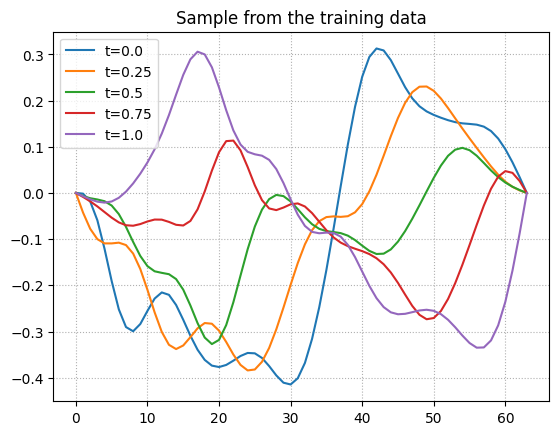

In [42]:
# plot a random sample from the training data
sample = train_data[np.random.randint(0, len(train_data))]

for t in range(len(sample)):
    plt.plot(sample[t, :, 0].numpy(), label=f't={t / 4}')

plt.grid(True, which="both", ls=":")
plt.title("Sample from the training data")
plt.legend()

In [43]:
learning_rate = 0.001
epochs = 500
step_size = 100
gamma = 0.5

In [44]:
modes = 16
width = 64
fno = FNO1d(modes, width)  # model

In [45]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = step_size, eta_min=1e-6)

# loss_f = torch.nn.MSELoss()
loss_f = relative_l2_error

In [46]:
fno.train()

metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    train_loss = 0.0
    for input_batch in train_data_loader:
        input = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        optimizer.zero_grad()
        prediction = fno(input).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)

    # Compute validation loss
    validation_relative_l2 = 0.0
    for input_batch in val_data_loader:
        input = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        with torch.no_grad():
            prediction = fno(input).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(val_data_loader)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step(validation_relative_l2)

    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
        }
    )


100%|██████████| 500/500 [00:45<00:00, 11.02it/s, train_loss=0.035, val_loss=0.0721] 


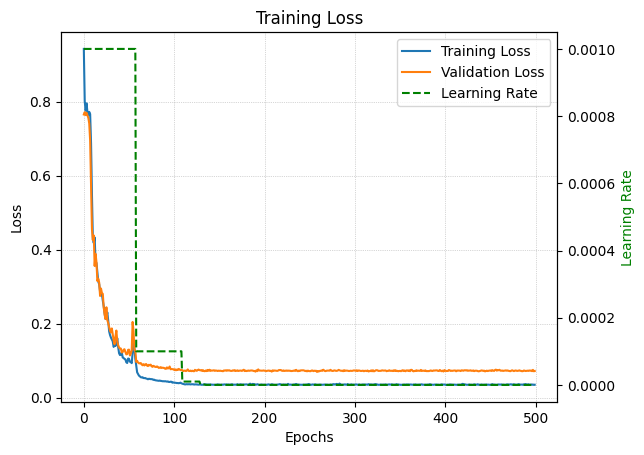

In [47]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.plot(metrics["training_loss"], label="Training Loss")
l2 = ax1.plot(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate", color="green")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [48]:
# save model to disk
torch.save(fno.state_dict(), "models/fno_model.pth")